Spotify Wrapped but for all music platforms
- Top song
- Top artist
- Top genre 

In [78]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re

spotify = pd.read_json('Spotify Account Data\StreamingHistory_music_0.json')
youtube = pd.read_json('Takeout\YouTube and YouTube Music\history\watch-history.json')

In [ ]:
#Convert spotify endTime to datetime
spotify['endTime'] = pd.to_datetime(spotify['endTime']) 
spotify['date'] = pd.to_datetime(spotify['endTime'].dt.date)
spotify['time'] = spotify['endTime'].dt.strftime('%H:%M')
spotify['hour'] = spotify['endTime'].dt.strftime('%H') #need hour for graph
spotify['hour'] = pd.to_numeric(spotify['hour']) 
spotify['year'] = spotify['endTime'].dt.strftime('%Y')

spotify = spotify[spotify['year']=='2024'] #only data from 2024

spotify.head()

,endTime,artistName,trackName,msPlayed,date,time,hour,year
340,2024-01-02 17:19:00,The Happy Fits,Hold Me Down,223813,2024-01-02,17:19,17,2024
341,2024-01-02 17:24:00,Olivia Rodrigo,vampire,219724,2024-01-02,17:24,17,2024
342,2024-01-02 17:27:00,Ricky Montgomery,Eraser,183114,2024-01-02,17:27,17,2024
343,2024-01-02 17:32:00,Olivia Rodrigo,the grudge,189386,2024-01-02,17:32,17,2024
344,2024-01-02 17:35:00,AJR,The Dumb Song,225946,2024-01-02,17:35,17,2024


In [ ]:
youtube = youtube[youtube['header']=='YouTube Music'] #only take data from youtube music 
youtube = youtube.drop(['titleUrl', 'products', 'activityControls', 'description', 'details', 'header'], axis=1)

#Convert youtube ListTime to datetime
youtube['ListTime'] = pd.to_datetime(youtube['time'], errors='coerce', utc=True)
youtube['date'] = pd.to_datetime(youtube['ListTime'].dt.date) 
youtube['time'] = youtube['ListTime'].dt.strftime('%H:%M')
youtube['hour'] = youtube['ListTime'].dt.strftime('%H') #need hour for graph
youtube['hour'] = pd.to_numeric(youtube['hour'])
youtube['year'] = youtube['ListTime'].dt.strftime('%Y')

youtube = youtube[youtube['year']=='2024'] #only take data from 2024

youtube.head()

,title,subtitles,time,ListTime,date,year,hour
2360,Watched Imran Khan - Pata Chalgea (Un-Official...,"[{'name': 'imrankhanworld', 'url': 'https://ww...",19:58,2024-12-31 19:58:04.072000+00:00,2024-12-31,2024,19.0
2361,Watched Gora Gora Rang,"[{'name': 'Imran Khan - Topic', 'url': 'https:...",19:55,2024-12-31 19:55:39.313000+00:00,2024-12-31,2024,19.0
2363,Watched Bewafa,"[{'name': 'Imran Khan - Topic', 'url': 'https:...",19:51,2024-12-31 19:51:46.123000+00:00,2024-12-31,2024,19.0
2364,Watched Amplifier,"[{'name': 'Imran Khan - Topic', 'url': 'https:...",19:47,2024-12-31 19:47:51.414000+00:00,2024-12-31,2024,19.0
2365,Watched Gasolina,"[{'name': 'Daddy Yankee - Topic', 'url': 'http...",19:44,2024-12-31 19:44:32.050000+00:00,2024-12-31,2024,19.0


In [ ]:
#Eliminate 'Watched' from song titles
def delete_watched(value): 
    pattern = r'^Watched '
    if re.match(pattern, value):
        cleaned = re.sub(r'^Watched ', '', value)
        return cleaned

youtube['title'] = youtube['title'].apply(delete_watched) 

#Get artist names from list in subtitles
youtube = youtube[~youtube['subtitles'].apply(lambda x: isinstance(x, float))] #drop float rows

def get_name(value): #Index artist names 
    return value[0]['name']

youtube['artist'] = youtube['subtitles'].apply(get_name) #Make artist column 

def delete_topic(value): #delete '- Topic' in names 
    pattern = r'.*\- Topic$'
    if re.match(pattern, value):
        cleaned = re.sub(r' \- Topic', '', value)
        return cleaned, True #add cleaned_flag for songs with author
    else: return value, False

youtube[['artist', 'cleaned_flag']] = youtube['artist'].apply(delete_topic).apply(pd.Series)
youtube.head()

#Eliminate random characters from titles and artists
youtube['title'] = youtube['title'].str.replace(r"[•·]", " ", regex=True)
youtube['artist'] = youtube['artist'].str.replace(r"[•·]", " ", regex=True)

artists = youtube[youtube['cleaned_flag']==True]['artist'].unique() #Create list of clean artists

sorted_artists = sorted(artists, key=len, reverse=True) #sort greatest to shortest to match longest

#Find artist from artist name in title
def find_artist(title): #Function to find artist name in title
    for artist in artists:
        if artist.lower() in title.lower():
            return artist
    return None
for idx, row in youtube[~youtube['cleaned_flag']].iterrows():
    artist_found = find_artist(row['title']) #change artist if found in title
    if artist_found:
        youtube.at[idx, 'artist'] = artist_found 

#Clean random words from song title
def clean_title(title):
    for artist in artists: #eliminate artist from title
        pattern = re.compile(re.escape(artist), re.IGNORECASE)
        title = pattern.sub('', title)
    cuts = ['(Un-Official Video)', '(Official Video)', '(lyrics)', '-', '(Official)', '(Audio)', '(Official Music Video)', '(feat. )']
    for phrase in cuts: #eliminate phrases from title
        pattern = re.compile(re.escape(phrase), re.IGNORECASE)
        title = pattern.sub('', title)
    title = title.strip()
    return title
youtube['title'] = youtube['title'].apply(clean_title)

In [93]:
#Take select columns from both dataframes to merge 
spotify2 = spotify[['artistName', 'trackName', 'date', 'hour']]
youtube2 = youtube[['artist', 'title', 'date', 'hour']]

#Create new column for listening platform
spotify2['platform'] = 'spotify'
youtube2['platform'] = 'youtube'

spotify2.rename(columns={'artistName': 'artist', 'trackName': 'title'}, inplace=True) #rename columns 

music = pd.concat([spotify2, youtube2], ignore_index=True) #merge dataframes 
music.head()

C:\Users\nylau\AppData\Local\Temp\ipykernel_17788\3023956668.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotify2['platform'] = 'spotify'
C:\Users\nylau\AppData\Local\Temp\ipykernel_17788\3023956668.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  youtube2['platform'] = 'youtube'
C:\Users\nylau\AppData\Local\Temp\ipykernel_17788\3023956668.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

,artist,title,date,hour,platform
0,The Happy Fits,Hold Me Down,2024-01-02,17.0,spotify
1,Olivia Rodrigo,vampire,2024-01-02,17.0,spotify
2,Ricky Montgomery,Eraser,2024-01-02,17.0,spotify
3,Olivia Rodrigo,the grudge,2024-01-02,17.0,spotify
4,AJR,The Dumb Song,2024-01-02,17.0,spotify


In [ ]:
#Print list of top 5 songs with artist name 
music['title'] = music['title'].astype(str)
song_freq = pd.crosstab(index=music['title'], columns='count') #create frequency count
song_freq = song_freq.reset_index()
top_songs = song_freq.sort_values('count', ascending=False)
song_freq['title'] = song_freq['title'].astype(str)

songs = song_freq.merge(music.drop_duplicates(subset='title'), on='title') #merge artist name 
songs = songs.sort_values('count', ascending=False)
songs = songs.drop(['date', 'hour'], axis=1)
songs.head() #print top songs with artist 

,title,count,artist
634,"Good Luck, Babe!",39,Chappell Roan
288,Calling After Me,31,Wallows
666,HOT TO GO!,31,Chappell Roan
1388,She Wants Me (To Be Loved),30,The Happy Fits
590,From The Start,30,Laufey


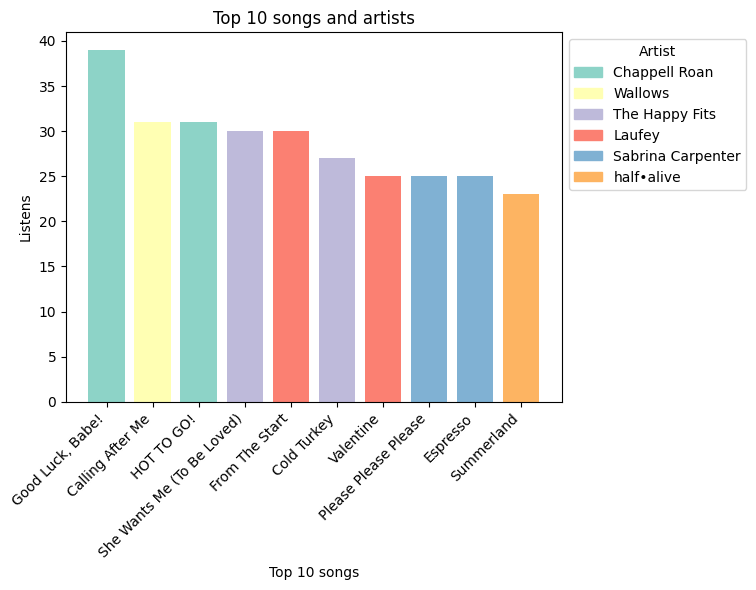

In [ ]:
#Create barplot of top 10 songs color coded for artist 
top10 = songs.head(10)
artists_names = top10['artist'].unique()
palette = sns.color_palette("Set3", len(artists_names))
artist_color_map = dict(zip(artists_names, palette)) 
colors = top10['artist'].map(artist_color_map) #unique color for each artist

plt.bar(x=top10['title'], height=top10['count'], color=colors) #graph top 10 song listens
plt.xticks(rotation=45, ha='right') 

handles = [plt.Rectangle((0,0),1,1, color=artist_color_map[artist]) for artist in artists_names]
plt.legend(handles, artists_names, title='Artist', bbox_to_anchor=(1, 1))
plt.xlabel("Top 10 songs")
plt.ylabel("Listens")
plt.title("Top 10 songs and artists")
plt.show()

In [ ]:
#Create list of top 5 artists 
artist_freq = pd.crosstab(index=music['artist'], columns='count') #frequency of top artists 
artist_freq = artist_freq.reset_index()
top_artist = artist_freq.sort_values('count', ascending=False)
top_artist.head()

col_0,artist,count
282,Noah Kahan,448
397,The Happy Fits,406
220,Laufey,387
77,Chappell Roan,352
480,half•alive,247


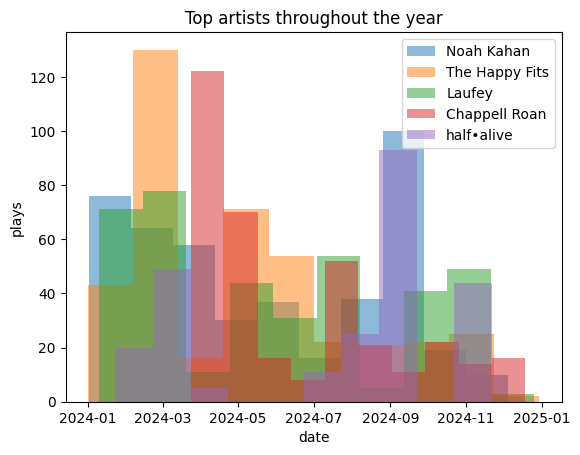

In [ ]:
#Create plot of top artist listens throughout the year 
top5_art = top_artist['artist'].head(5).unique() #list of top 5 artists

plt.figure() #plot of top 5 artist listens throughout the year
for artist in top5_art:
    sp = music[music['artist'] == artist]
    plt.hist(sp['date'], label=artist, alpha=0.5)

plt.legend()
plt.xlabel('date')
plt.ylabel('plays')
plt.title("Top artists throughout the year")
plt.show()

<Axes: xlabel='date', ylabel='Count'>

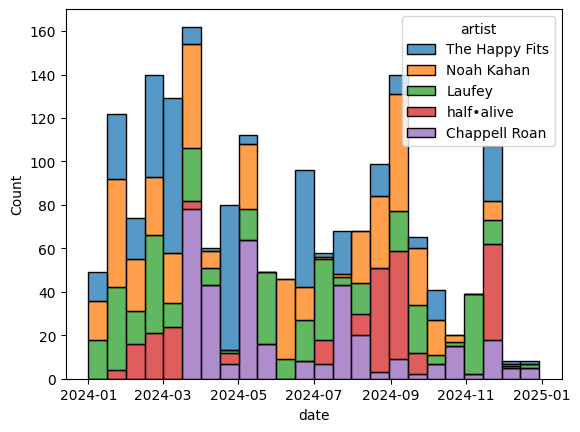

In [ ]:
top5 = music[music['artist'].isin(top5_art)]
sns.histplot(data=top5, x='date', hue='artist', multiple='stack', bins=24)

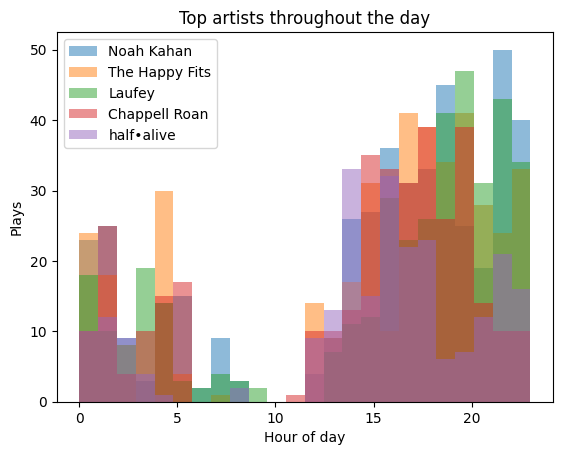

In [ ]:
#Create plot of top 5 artist listens throughout day time 
plt.figure() 
for artist in top5_art:
    sp = music[music['artist'] == artist]
    plt.hist(sp['hour'], bins=24, label=artist, alpha=0.5)

plt.legend()
plt.xlabel("Hour of day")
plt.ylabel("Plays")
plt.title("Top artists throughout the day")
plt.show()

<Axes: xlabel='hour', ylabel='Count'>

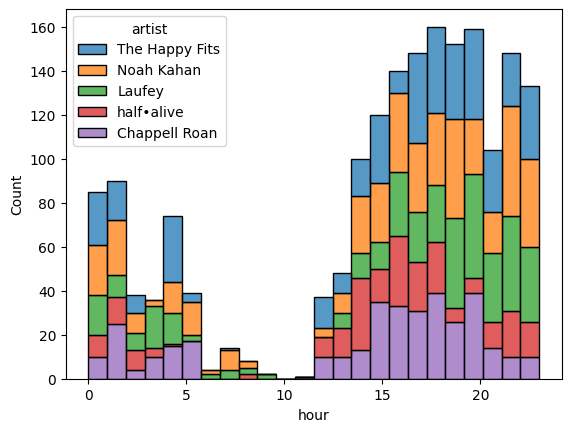

In [100]:
sns.histplot(data=top5, x='hour', hue='artist', multiple='stack', bins=24)

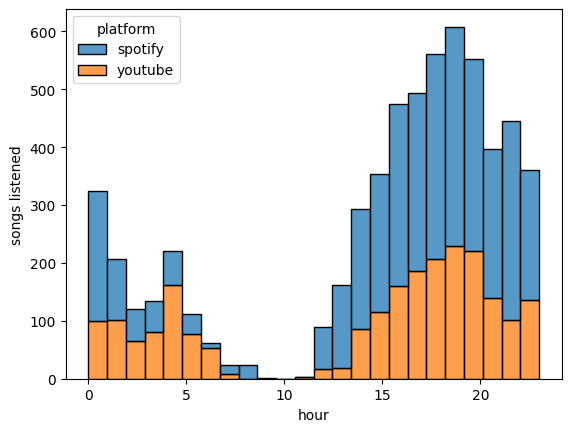

In [ ]:
#Histogram for platforms used throughout the day
sns.histplot(data=music, x='hour', hue='platform', multiple='stack', bins=24, shrink=1.0)

plt.ylabel('songs')
plt.title('Platforms used throughout the day')
plt.show()

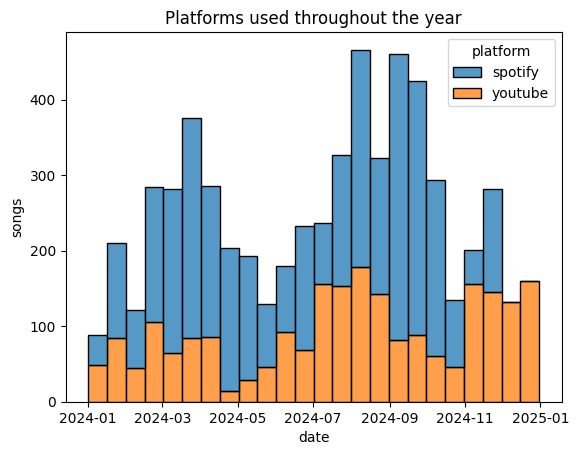

In [98]:
sns.histplot(data=music, x='date', hue='platform', multiple='stack', bins=24, shrink=1.0)

plt.ylabel('songs')
plt.title('Platforms used throughout the year')
plt.show()